In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
from src.tfno import FNO1d
from src.utils import relative_l2_error, smoothness_loss
from src.dataset import PDEDatasetAll2All

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
N_TRAIN = 64 # number of trajectory samples
BATCH_SIZE = 256
DEVICE = "mps"

# Training Model

In [4]:
training_data = PDEDatasetAll2All("data/train_sol.npy", device=DEVICE, augment_data=True)

samples_total = N_TRAIN * 2 * training_data.len_times

# choose samples_total samples randomly
train_data, val_data = torch.utils.data.random_split(
    training_data, [samples_total, len(training_data) - samples_total]
)
print(f"{len(training_data)} samples total")
print(f"Training with {len(train_data)} samples")
print(f"Validating with {len(val_data)} samples")

2560 samples total
Training with 1280 samples
Validating with 1280 samples


In [5]:
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
learning_rate = 0.001
epochs = 250
step_size = 10
gamma = 0.5

In [7]:
modes = 16
width = 64
fno = FNO1d(modes, width).to(DEVICE)  # model

In [8]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CyclicLR(
    base_lr=learning_rate / step_size,
    max_lr=learning_rate * 2,
    mode="exp_range",
    optimizer=optimizer,
    step_size_up=step_size,
    gamma=gamma,
)

In [9]:
def loss_f(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    return relative_l2_error(output, target) + 1e-7 * smoothness_loss(output)

In [10]:
metrics = {
    "training_loss": [],
    "validation_loss": [],
    "lr": [],
}

In [11]:
progress_bar = tqdm.tqdm(range(epochs))
for epoch in progress_bar:
    fno.train()
    train_loss = 0.0
    for i, (dt, input, target) in enumerate(train_data_loader):
        optimizer.zero_grad()
        prediction = fno(input, dt).squeeze(-1)

        loss = loss_f(prediction, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_data_loader)
    scheduler.step()

    metrics["training_loss"].append(train_loss)
    metrics["lr"].append(scheduler.get_last_lr())

    # Compute validation loss
    with torch.no_grad():
        fno.eval()
        validation_relative_l2 = 0.0
        for i, (dt, input, target) in enumerate(val_data_loader):
            prediction = fno(input, dt).squeeze(-1)

            loss = relative_l2_error(prediction, target)
            validation_relative_l2 += loss.item()

        validation_relative_l2 /= len(val_data_loader)
        metrics["validation_loss"].append(validation_relative_l2)

    # Update progress bar
    progress_bar.set_postfix(
        {"train_loss": train_loss, "val_loss": validation_relative_l2}
    )

100%|██████████| 250/250 [04:48<00:00,  1.15s/it, train_loss=0.317, val_loss=0.364]


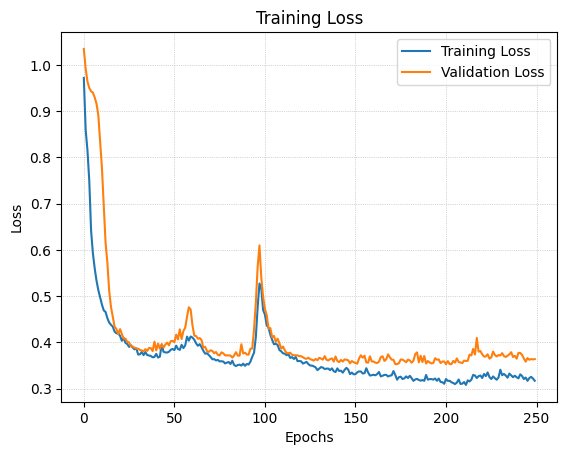

In [12]:
plt.plot(metrics["training_loss"], label="Training Loss")
plt.plot(metrics["validation_loss"], label="Validation Loss")
# plt.plot(learning_rates, label="Learning Rate")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True, which="both", ls=":", linewidth=0.5)
plt.show()

## Evaluating the model on test set (at $t=1.0$)

In [13]:
dataset_test = PDEDatasetAll2All("data/test_sol.npy", device=DEVICE, time_pairs=[(0, 4)])
test_data_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

In [14]:
fno.eval()
progress_bar = tqdm.tqdm(test_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    for i, (dt, input, target) in enumerate(progress_bar):
        prediction = fno(input, dt).squeeze(-1)

        loss = relative_l2_error(prediction, target)
        test_relative_l2 += loss.item()
    test_relative_l2 /= len(test_data_loader)

print(rf"Test relative L2 error (only predictions at t=1.0): {test_relative_l2}")

100%|██████████| 128/128 [00:01<00:00, 64.43it/s]

Test relative L2 error (only predictions at t=1.0): 0.43512605654541403


In [15]:
# save model to disk
torch.save(fno.state_dict(), "models/tfno_model.pth")